In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import select
from skimage import feature as ft
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import sys
from sklearn import mixture

importpath   = "../../../Dataset/"
testrainpath = ["Testing", "Training"]
namespath    = ["/Abed/", "/Daniel/", "/Jules/", "/Lea/", "/Patrick/"]
rescaledpath = "Rescaled"
croppedpath  = "Cropped"

meta_data = {0: 'Abed', 1: 'Daniel', 2: 'Jules', 3: 'Lea', 4: 'Patrick'}

def get_data(isCropped=True):

    # Test train data
    X_train = []
    Y_train = []

    X_test  = []
    Y_test  = []

    # define both import paths
    testpath = importpath+testrainpath[0]
    trainpath= importpath+testrainpath[1]

    for i, npath in enumerate(namespath):

        if isCropped:
            testfolder = testpath + croppedpath + npath
            trainfolder= trainpath+ croppedpath + npath
        else:
            testfolder = testpath + rescaledpath + npath
            trainfolder= trainpath+ rescaledpath + npath

        for imgname in os.listdir(testfolder):

            img = cv2.imread(testfolder+imgname)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            X_test.append(img)
            Y_test.append(i)

        for imgname2 in os.listdir(trainfolder):

            img = cv2.imread(trainfolder+imgname2)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            X_train.append(img)
            Y_train.append(i)

#     # once the data is saved, shuffle it
#     X_train , Y_train = shuffle(X_train, Y_train)
#     X_test  , Y_test  = shuffle(X_test, Y_test)

    return np.asarray(X_train), np.asarray(Y_train), np.asarray(X_test), np.asarray(Y_test), meta_data


In [19]:
def sift(img):

    # copy image
    img_disp = img.copy()
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

    # create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # detect SIFT features, with no masks
    keypoints = sift.detect(img, None)
    
    p = []
    keypoints3, descriptors = sift.compute(img, keypoints)
    for k in keypoints3:
        p.append(k.pt)

    # draw the keypoints
    cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# #     display
#     plt.figure(figsize=(10, 10))
#     plt.subplot(121), plt.imshow(img)
#     plt.title("Input Image"), plt.xticks([]), plt.yticks([])
#     plt.subplot(122), plt.imshow(img_disp)
#     plt.title("SIFT Features"), plt.xticks([]), plt.yticks([])
#     plt.show()

#     # num of SIFT keypoints
#     print('Num keypoints: ' + str(len(keypoints)))

    return p


# Get croppped image coordinates in original image (x,y in top left corner)
def get_coordinates(img_rescaled, img_cropped):
    # imgggg_rgb = cv2.imread("../../../Dataset/TrainingRescaled/Abed/scale1_0.jpeg")
    # img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    # template = cv2.imread("../../../Dataset/TrainingCropped/Abed/scale1_0.jpeg", 0)
    img_rescaled = cv2.cvtColor(img_rescaled, cv2.COLOR_BGR2GRAY)
    img_cropped = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
    w, h = img_cropped.shape[::-1]
    res = cv2.matchTemplate(img_rescaled, img_cropped, cv2.TM_SQDIFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = min_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    x = top_left[0]
    y = top_left[1]
    return x, y


def make_patch(img,img_cropped, size, k):
    # get patch centers
    patch_centers = []
    for i in k:
        patch_centers.append(i)

    # extract patches
    patch_images = []
    patch_size = size
    count=0
    for center in patch_centers:
        patchXStart = int(center[0] - (patch_size / 2.))
        patchYStart = int(center[1] - (patch_size / 2.))
        if((center[0] + patch_size)>img_cropped.shape[1] or (center[0] - patch_size)<0 or (center[1] + patch_size)>img_cropped.shape[0] or (center[1] - patch_size)<0 ):
            count+=1
            x,y = get_coordinates(img, img_cropped)
            patchXStart += x
            patchYStart += y
            patch_images.append(img[patchXStart:patchXStart + patch_size, patchYStart:patchYStart + patch_size])
        else:
            patch_images.append(img_cropped[patchXStart:patchXStart + patch_size, patchYStart:patchYStart + patch_size])

#     print("count= " , count)
#     # display
#     for im in patch_images:
#         plt.figure(figsize=(5, 5))
#         plt.imshow(im)
#         plt.title("Input Image"), plt.xticks([]), plt.yticks([])
#         plt.show()
    return patch_images


# ----- HoG Function ----- #
def rgb2gray(im):
    gray = im[:, :, 0] * 0.2989 + im[:, :, 1] * 0.5870 + im[:, :, 2] * 0.1140
    return gray

def hog_features(imgs, cells):
    train_x = []
    for data in imgs:
        gray = rgb2gray(data) / 255.0
        x = ft.hog(gray, orientations=9, pixels_per_cell=(2, 2),
                   cells_per_block=(cells, cells))
        train_x.append(x)
    return train_x

def get_hog(patches, cell_size):
    hog_patches = []
    for patch in patches:
        hog_ft = hog_features(patch, cell_size)
        hog_patches.append(hog_ft)
    hog_flat = []
    for h in hog_patches:
        hog_flat.append(np.asarray(h).flatten().ravel())
    h = np.asarray(hog_flat)
    return h

def get_em(x_train_hog, y_train, x_test_hog, y_test):
    
    '''
    Covariance is spherical since it's the fastest one
    With Full Covariance, device was running out of memory
    '''
    print("GMM")
    gmm = mixture.GaussianMixture(n_components=5, covariance_type='spherical')
    fit_data = gmm.fit(x_train_hog)
    labels = gmm.predict(x_test_hog)
    accuracy = (np.mean(y_test == labels))
    
    return fit_data, accuracy, labels
    

GMM
Validation Accuracy :  0.2


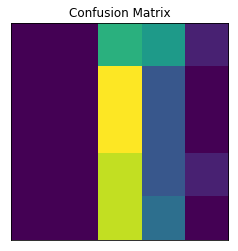

In [22]:
if __name__ == '__main__':

   # Load Cropped Data

    cropped_data = get_data(isCropped=True)
    X_train_cropped = cropped_data[0]
    Y_train_cropped = cropped_data[1]
    X_test_cropped = cropped_data[2]
    Y_test_cropped = cropped_data[3]
    metadata_cropped = cropped_data[4]
    
    # Load Original Data
    
    data = get_data(isCropped=False)
    X_train = data[0]
    Y_train = data[1]
    X_test = data[2]
    Y_test = data[3]
    metadata = data[4]

    # Train Images

    patches_train_list = []
    for i in range(0, len(X_train_cropped)):
        cropped_img = X_train_cropped[i]
        original_img = X_train[i]
        kp = sift(cropped_img)
        patches_train = make_patch(img=original_img,img_cropped=cropped_img, size=15, k=kp[:15])
        patches_train_list.append(patches_train)


    # Test Images

    patches_test_list = []
    for i in range(0, len(X_test_cropped)):  
        cropped_img_test = X_test_cropped[i]
        original_img_test = X_test[i]
        kp = sift(cropped_img_test)
        patches_test = make_patch(img=original_img_test,img_cropped=cropped_img_test, size=15, k=kp[:15])
        patches_test_list.append(patches_test)

    # HOG - Training Patches

    h_3_train = get_hog(patches_train_list, 3)
    h_4_train = get_hog(patches_train_list, 4)
    h_5_train = get_hog(patches_train_list, 5)

    # HOG - Testing Patches

    h_3_test = get_hog(patches_test_list, 3)
    h_4_test = get_hog(patches_test_list, 4)
    h_5_test = get_hog(patches_test_list, 5)
    
    # Run EM
    
    fit_data, accuracy, labels = get_em(h_3_train, Y_train, h_3_test, Y_test)
    print("Validation Accuracy : " ,accuracy)
    
    # Create the confusion matrix
    conf = confusion_matrix(Y_test, labels)

    # display
    plt.figure()
    plt.imshow(conf)
    plt.title("Confusion Matrix"), plt.xticks([]), plt.yticks([])
    plt.show()


Accuracy  0.2571428571428571


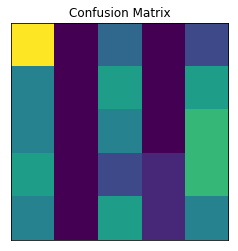

Accuracy  0.2


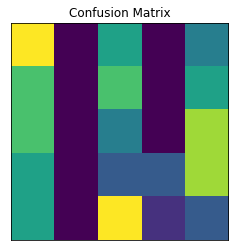

Accuracy  0.2571428571428571


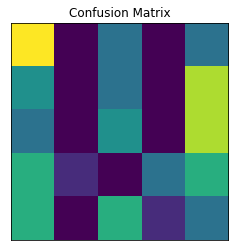

In [23]:
from sklearn.neighbors import KNeighborsClassifier

h_tr = [h_3_train, h_4_train, h_5_train]
h_ts = [h_3_test, h_4_test, h_5_test]
for i in range(3):
    model = KNeighborsClassifier(n_neighbors=5)

    # Train the model using the training sets
    model.fit(h_tr[i], Y_train)

    predict = model.predict(h_ts[i])

    sln = np.zeros(2)
    for i in range(len(predict)):
        if(Y_test[i] == predict[i]):
            sln[0]+=1
        else:
            sln[1]+=1

    print('Accuracy ', sln[0]/(sln[0]+sln[1]))

    conf = confusion_matrix(Y_test, predict)
    plt.figure()
    plt.imshow(conf)
    plt.title("Confusion Matrix"), plt.xticks([]), plt.yticks([])
    plt.show()

In [25]:
model = KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets
model.fit(h_tr[0], Y_train)


predict = model.predict(h_ts[0])

sln = np.zeros(2)
for i in range(len(predict)):
    if(Y_test[i] == predict[i]):
        sln[0]+=1
    else:
        sln[1]+=1

print('Accuracy ', sln[0]/(sln[0]+sln[1]))



Accuracy  0.2571428571428571


In [ ]:
for i in range(5):
    k = len(h_3_train[i])
    print(k)
    plt.bar(range(k), h_3_train[i][:15])
    plt.show() 

In [32]:
k = (h_3_train[0][:15])
print(k)

[0.10231661 0.         0.         0.         0.27059261 0.
 0.         0.         0.         0.10297642 0.         0.
 0.         0.         0.2443523 ]


15


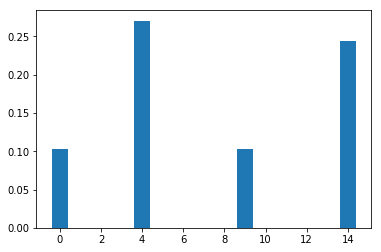

In [36]:
k = len(h_3_train[0][:15])
print(k)
plt.bar(range(k), h_3_train[0][:15])
plt.show() 